# Tutorial 07 - Processing seismic data I

First let's import some modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import pestoseis.seismicwaves2d as sw
import pestoseis.reflectionseismo as rs

## Acoustic waves simulation

Input parameters to run the finite difference code

In [2]:
# time
nt = 4000
dt = 0.0003 #s 
t = np.arange(0.0,nt*dt,dt) # s

# space
nx = 438 
nz = 240 
dh = 3.5 # m 

###############################

# source position
lineIdep = 35 #70 # 70
ijsrc = np.array([40,lineIdep]) 

# receivers
# Create a shotgather, receivers along a horizontal line
nrec = 60
xrec = np.linspace(40*dh,(nx-30)*dh,nrec)
nrec = len(xrec)
recpos = np.zeros((nrec,2))
recpos[:,0] = xrec
recpos[:,1] = (lineIdep)*dh

###############################

# source time function
t0 = 0.07 # s
f0 = 20.0 # Hz
  
sourcetf = 1e2 * sw.rickersource( t, t0, f0 )
#sourcetf = sw.gaussource( t, t0, f0 )

###############################

## input parameters
inpar={}
inpar["ntimesteps"] = nt
inpar["nx"] = nx
inpar["nz"] = nz
inpar["dt"] = dt
inpar["dh"] = dh
inpar["savesnapshot"] = True
inpar["snapevery"]    = 50
inpar["freesurface"]  = True
inpar["boundcond"]    = "PML"  ## "PML" only choice in this code...

Velocity model

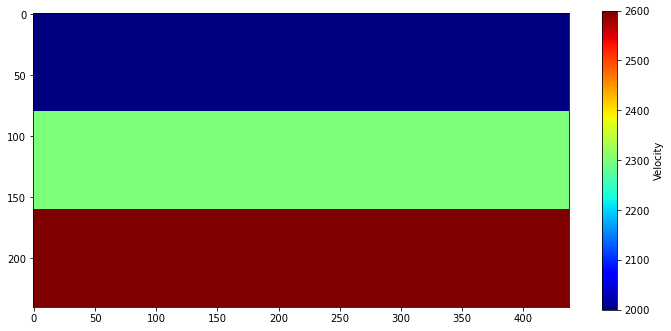

In [3]:
velmod = np.zeros((nx,nz))
velmod[:,:] = 2000.0
velmod[:,80:160] = 2300.0
velmod[:,160:] = 2600.0

plt.figure(figsize=(12,5.5))
plt.imshow(velmod.T,cmap=plt.get_cmap("jet"))
plt.colorbar(label="Velocity")
plt.show()

Run the acoustic simulation

In [4]:
t1 = time.time()    
seism,psave = sw.solveacoustic2D( inpar, ijsrc, velmod, sourcetf, f0, recpos )        
t2 = time.time()
print(("Solver time: {}".format(t2-t1)))

Starting ACOUSTIC solver with CPML boundary condition.
 Stability criterion, CFL number: 0.3151675939002897
 * Free surface at the top *
 Size of PML layers in grid points: 21 in x and 21 in z
 Time step dt: 0.0003
 Time step 3900 of 4000 
Saved acoustic simulation and parameters to  acoustic_snapshots.h5
Solver time: 15.726963996887207


### Plot the shotgather

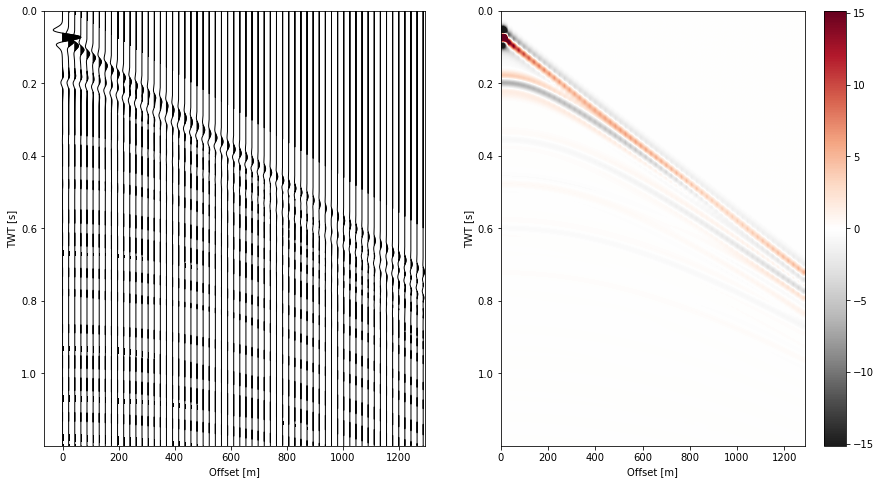

In [5]:
# Compute offset
offset = recpos[:,0]-recpos[0,0]

# Plot shotgather both as image and as wiggles
plt.figure(figsize=(15,8))
plt.subplot(121)
rs.wiggle(seism,dt,offset=offset,scal=3.0)

plt.subplot(122)
vmax = 0.5*np.abs(seism).max()
rs.imgshotgath(seism,dt,offset,amplitudeclip=0.2)

plt.show()

### Amplitude enhancement

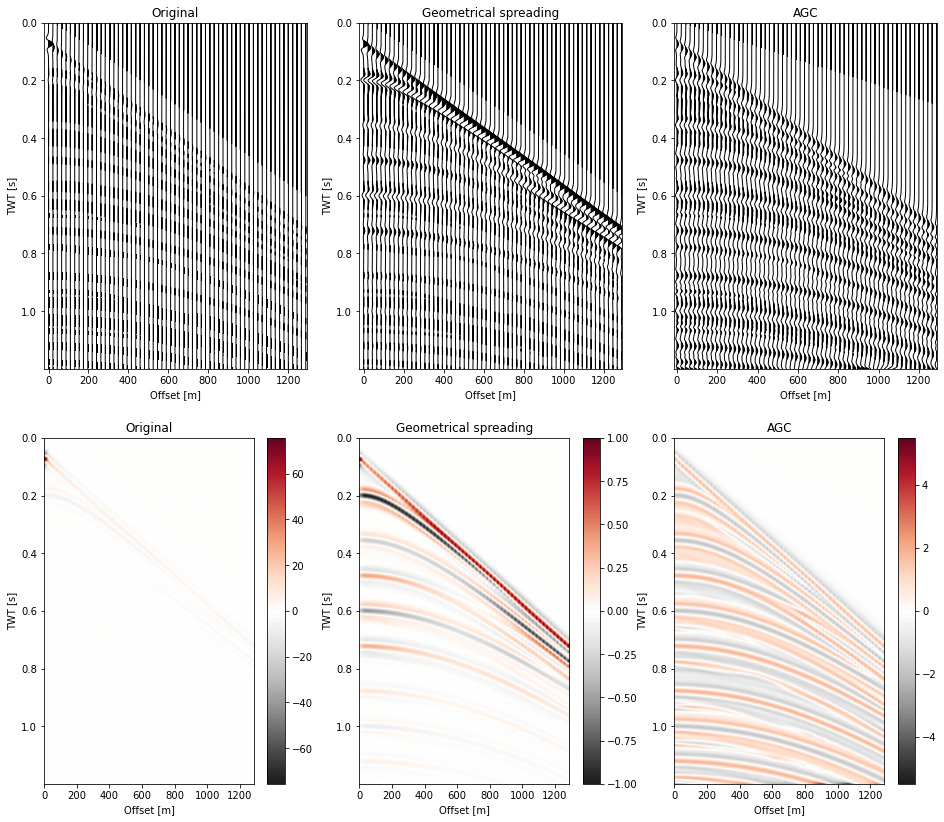

In [6]:
# TWT array (travel time)
twt = np.arange(0.0,nt*dt,dt)

# Geometrical spreading correction
geomsp = rs.geometrical_spreading(seism,twt)
# Amplitude gain correction (AGC)
agccor = rs.agc(geomsp, w=100)


plt.figure(figsize=(16,14))

plt.subplot(231)
plt.title("Original")
rs.wiggle(seism,dt,offset=offset)

plt.subplot(232)
plt.title("Geometrical spreading")
rs.wiggle(geomsp,dt,offset=offset)

plt.subplot(233)
plt.title("AGC")
rs.wiggle(agccor,dt,offset=offset)

plt.subplot(234)
plt.title("Original")
rs.imgshotgath(seism,dt,offset)

plt.subplot(235)
plt.title("Geometrical spreading")
rs.imgshotgath(geomsp,dt,offset)

plt.subplot(236)
plt.title("AGC")
rs.imgshotgath(agccor,dt,offset)


### Normal moveout correction

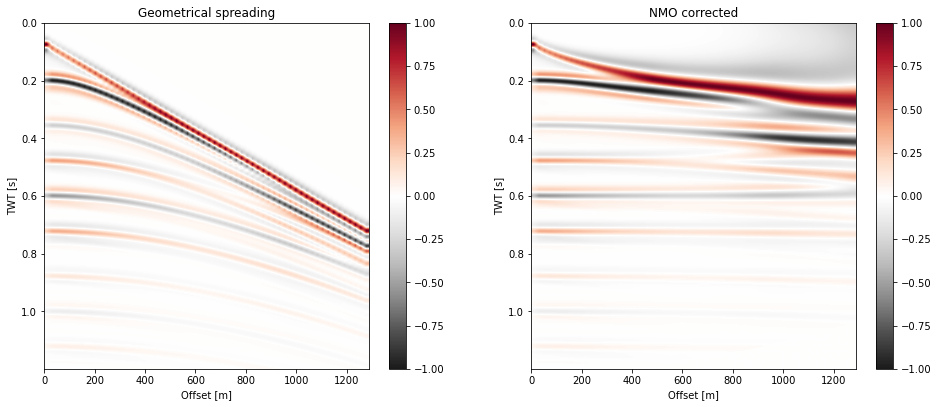

In [7]:

velnmo = np.zeros(seism.shape[1])
velnmo[:] = np.linspace(1850.0,2200.0,seism.shape[1])
snmo = rs.nmocorrection(velnmo,dt,offset,geomsp)


plt.figure(figsize=(16,14))

plt.subplot(221)
plt.title("Geometrical spreading")
rs.imgshotgath(geomsp,dt,offset,amplitudeclip=1)

plt.subplot(222)
plt.title("NMO corrected")
rs.imgshotgath(snmo,dt,offset,amplitudeclip=1)

#rs.wiggle(snmo,dt,offset=offset)

## Create a movie

In [8]:
#%matplotlib notebook


anim = sw.animateacousticwaves("acoustic_snapshots.h5",clipamplitude=0.1,showanim=False) 
plt.close(anim._fig)

from IPython.display import HTML
HTML(anim.to_html5_video())
